In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

In [4]:
df = pd.read_parquet('df.sample.parquet.gzip')
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id
6733995,2019-10-06 08:34:28+00:00,view,16700605,2053013559901684381,furniture.kitchen.chair,zeta,16.190001,518195082
4880941,2019-10-10 08:31:52+00:00,view,4800725,2053013554658804075,electronics.audio.headphone,sony,8.210000,512421337
6895456,2019-10-26 08:07:34+00:00,view,8800489,2053013555573162395,electronics.telephone,hiper,12.100000,518901124
807139,2019-10-07 06:33:45+00:00,cart,4201420,2053013552351936731,appliances.environment.air_conditioner,lg,787.630005,520085572
6297826,2019-10-25 18:07:49+00:00,view,1004739,2053013555631882655,electronics.smartphone,xiaomi,189.970001,513345774


In [5]:
df = df.drop('category_id', axis=1)
df.shape

(1000000, 7)

<AxesSubplot:xlabel='price'>

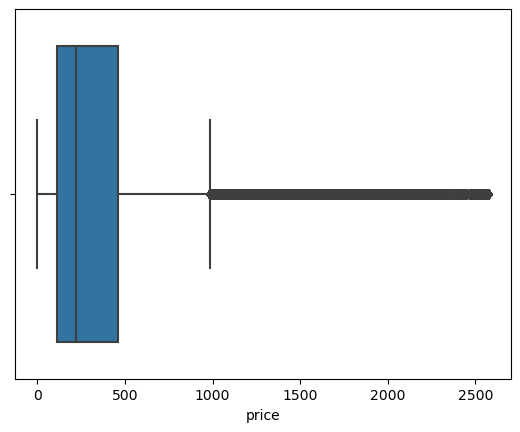

In [6]:
sns.boxplot(data=df, x='price')

In [7]:
df['price'].describe()

count    1000000.000000
mean         352.464996
std          380.233673
min            0.000000
25%          109.080002
50%          218.490005
75%          459.070007
max         2574.070068
Name: price, dtype: float64

In [8]:
df[df['price'] <= 0]['event_type'].unique()

['view', 'cart']
Categories (3, object): ['cart', 'purchase', 'view']

In [9]:
df[df['user_id'] == 244951053]

,event_time,event_type,product_id,category_code,brand,price,user_id
2489108,2019-10-03 03:06:18+00:00,view,1005105,electronics.smartphone,apple,1415.47998,244951053


In [10]:
df = df[df['event_type'] == 'purchase']
df.shape

(20576, 7)

# RFM 계산
 - 전체 주문에서 최근 주문일 구하기

In [11]:
last_timestamp = df['event_time'].max() + dt.timedelta(days=1)
last_timestamp

Timestamp('2019-11-01 23:49:19+0000', tz='UTC')

In [12]:
rfm = df.groupby('user_id').agg({'event_time' : lambda x: (last_timestamp - x.max()).days,
                                'product_id' : 'count',
                                'price' : 'sum'})
rfm

,event_time,product_id,price
user_id,,,
435648894,26,1,388.130005
437371552,30,1,179.139999
450756413,29,1,43.730000
456810531,7,1,133.350006
473668240,23,1,149.039993
...,...,...,...
566188229,1,1,221.339996
566210490,1,1,514.780029
566227458,1,1,465.910004


In [17]:
rfm = rfm.rename(columns={"event_time": "Recency", 
                          "product_id": "Frequency", 
                          "price": "MonetaryValue"})
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M
user_id,,,,,,
435648894,26,1,388.130005,2,1,4
437371552,30,1,179.139999,1,1,2
450756413,29,1,43.730000,1,1,1
456810531,7,1,133.350006,4,1,2
473668240,23,1,149.039993,2,1,2


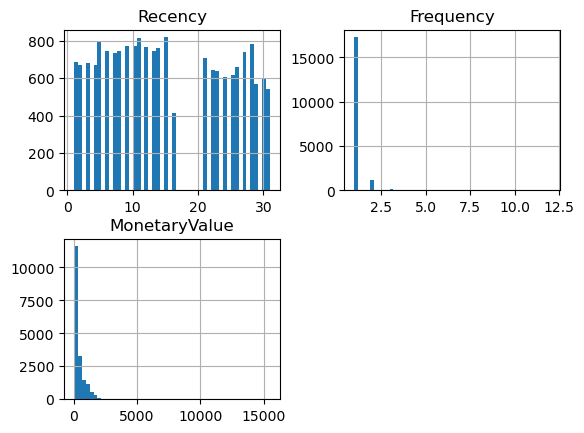

In [18]:
rfm.hist(bins=50);

# Scoring 기법
- R은 값이 낮을 수록 최근에 구매한 고객이기 때문에 높은 점수를 줄 예정입니다.
- F, M은 값이 높을 수록 높은 점수를 부여

In [19]:
cut_size=5
r_cut = pd.qcut(rfm['Recency'].rank(method='first'), cut_size, labels=list(range(5,0,-1)))
f_cut = pd.qcut(rfm['Frequency'].rank(method='first'), cut_size, labels=list(range(1,6)))
m_cut = pd.qcut(rfm['MonetaryValue'].rank(method='first'), cut_size, labels=list(range(1,6)))

In [21]:
# assign 을 사용하면 여러 변수를 한 번에 만들 수 있습니다.
rfm = rfm.assign(R=r_cut, F=f_cut, M=m_cut)
rfm

,Recency,Frequency,MonetaryValue,R,F,M
user_id,,,,,,
435648894,26,1,388.130005,2,1,4
437371552,30,1,179.139999,1,1,2
450756413,29,1,43.730000,1,1,1
456810531,7,1,133.350006,4,1,2
473668240,23,1,149.039993,2,1,2
...,...,...,...,...,...,...
566188229,1,1,221.339996,5,5,3
566210490,1,1,514.780029,5,5,4
566227458,1,1,465.910004,5,5,4


# RFM Segment

In [22]:
# RFM_segment 값을 구합니다. 
# R, F, M 값을 문자 그대로 붙여서 세그먼트를 구분합니다.
rfm["RFM_segment"] = rfm["R"].astype(str) + rfm["F"].astype(str) + rfm["M"].astype(str)

# RFM Score

In [23]:
# R, F, M 값의 합계를 구해서 세그먼트 점수를 구합니다.
rfm["RFM_score"] = rfm[["R", "F", "M"]].sum(axis=1)
rfm.head(2)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score
user_id,,,,,,,,
435648894,26,1,388.130005,2,1,4,214,7
437371552,30,1,179.139999,1,1,2,112,4


<AxesSubplot:xlabel='RFM_segment', ylabel='RFM_score'>

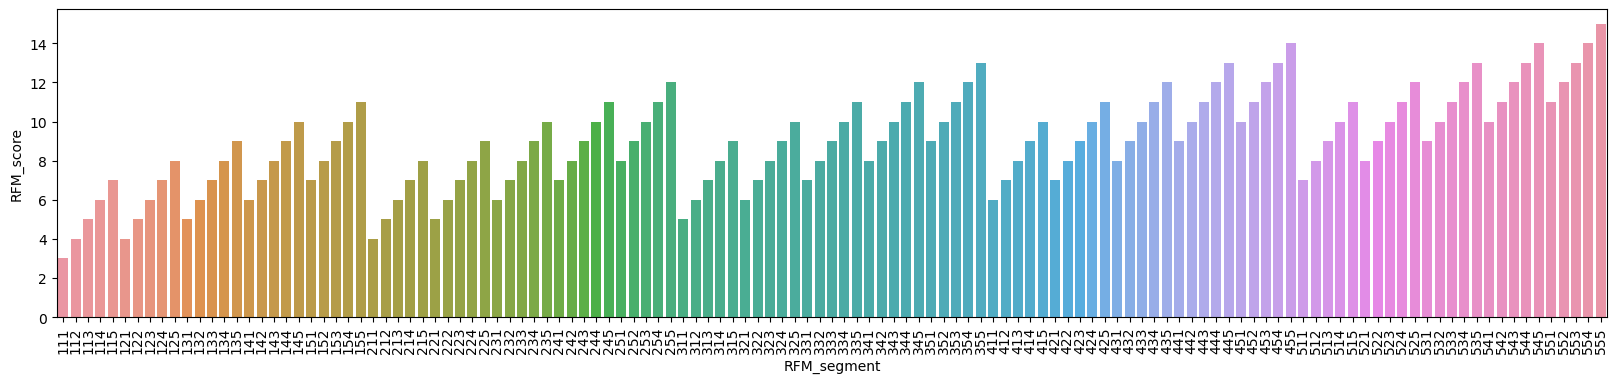

In [24]:
# RFM segment 값에 따라 정렬합니다.
plt.figure(figsize=(20, 4))
plt.xticks(rotation=90)
sns.barplot(data=rfm.sort_values("RFM_segment"), x="RFM_segment", y="RFM_score")

In [25]:
# Recency : 최근 거래 기준일(last_timestamp)과 고객별 최근 구매한 날짜(x.max())와 차이값
# Frequency : 구매 빈도수
# Monetary : 총 구매 금액
# 문자열의 format 함수를 사용하여 소수점 아래는 표기하지 않도록({:,.0f}) 문자열 포맷을 지정합니다.
rfm.groupby("RFM_score").agg({"Recency": "mean", 
                              "Frequency" : "mean", 
                              "MonetaryValue" : ["mean", "sum"]
                             }).style.background_gradient().format("{:,.0f}")

In [26]:
# qcut 을 통해 3단계로 "silver", "gold", "platinum" 고객군을 나눕니다. 
rfm["RFM_class"] = pd.qcut(rfm["RFM_score"], 
                           q=3, 
                           labels=["silver", "gold", "platinum"])

In [27]:
# "RFM_class" 별로 그룹화 하고 "RFM_score" 의 describe() 값을 구합니다.
# RFM_score 에 따라 RFM_class 값이 잘 나뉘었는지 확인
rfm.groupby("RFM_class")["RFM_score"].describe()

,count,mean,std,min,25%,50%,75%,max
RFM_class,,,,,,,,
silver,8366.0,6.608535,1.308346,3.0,6.0,7.0,8.0,8.0
gold,4870.0,9.486448,0.499868,9.0,9.0,9.0,10.0,10.0
platinum,5448.0,12.237518,1.248803,11.0,11.0,12.0,13.0,15.0


In [28]:
rfm.groupby('RFM_class').agg({'Recency':'mean', 'Frequency':'mean',
                             'MonetaryValue':['mean', 'sum', 'count']})

Recency Frequency MonetaryValue                   
                mean      mean          mean          sum count
RFM_class                                                      
silver     20.515300  1.003586    218.376770  1826940.000  8366
gold       13.768994  1.025462    414.418610  2018218.625  4870
platinum    7.986784  1.319016    697.116882  3797892.750  5448

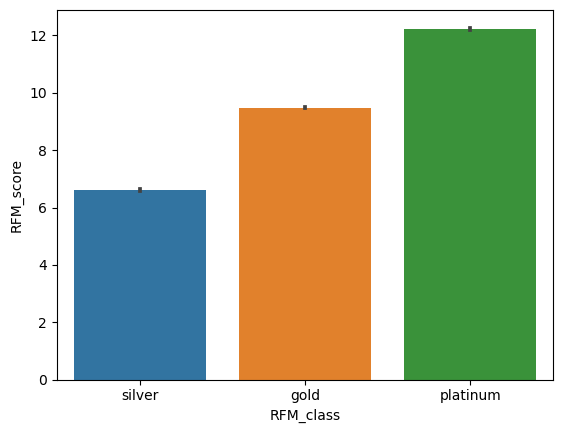

In [29]:
sns.barplot(data=rfm, x="RFM_class", y="RFM_score");

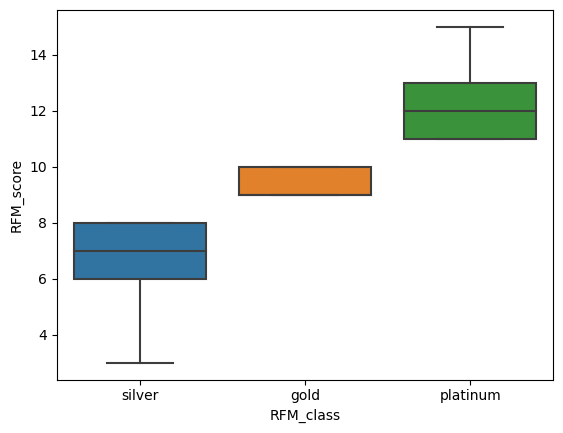

In [30]:
sns.boxplot(data=rfm, x="RFM_class", y="RFM_score");

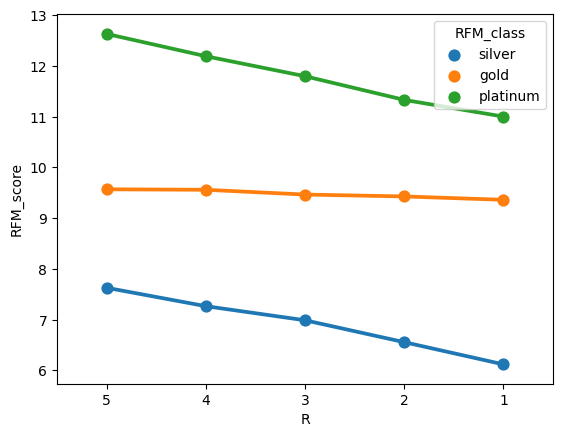

In [31]:
sns.pointplot(data=rfm, x='R', y='RFM_score', hue='RFM_class');